In [3]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import SubsetRandomSampler, DataLoader
from torchvision import transforms as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

%cd ../
from src.data.datasets import HandwritingDataset
from src.models import HandwritingClassifier
%cd notebooks/

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/nazar/Projects/ukrainian_handwriting
/home/nazar/Projects/ukrainian_handwriting/notebooks
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = torch.device("cuda:0")

# Loading train/test/val

In [3]:
MEAN = HandwritingClassifier._mean
STD = HandwritingClassifier._std

In [5]:
tfs = tf.Compose([
    tf.Resize((28, 28)),
    tf.ToTensor(),
    tf.Normalize(mean=MEAN, std=STD)
])

In [6]:
train_data = HandwritingDataset(
    '../data/processed/train_data.csv',
    transforms=tfs
)

test_data = HandwritingDataset(
    '../data/processed/test_data.csv',
    transforms=tf.Compose([
        tf.Resize((28, 28)),
        tf.ToTensor(),
        tf.Normalize(mean=MEAN, std=STD)
    ])
)

print('Number of samples in training data:', len(train_data))
print('Number of samples in test data:', len(test_data))

Number of samples in training data: 981
Number of samples in test data: 100


In [7]:
BATCH_SIZE = 64
VAL_SIZE = 100

indices = list(range(len(train_data)))
np.random.seed(42)
np.random.shuffle(indices)
train_indices, val_indices = indices[VAL_SIZE:], indices[:VAL_SIZE]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(train_data, BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(train_data, sampler=val_sampler)
test_loader = DataLoader(test_data)

# Functions for training

In [8]:
def compute_accuracy(model, loader):
    model.eval()
    correct_samples = 0
    total_samples = 0
    for i, (x, y, _) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = torch.argmax(model(x_gpu), 1)
        
        correct_samples += torch.sum(prediction == y_gpu)
        total_samples += y.shape[0]
    return float(correct_samples) / total_samples

def train_model(model, train_loader, val_loader, optimizer, loss, num_epochs, scheduler=None):
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train()
        
        loss_acum = 0
        total_samples = 0
        correct_samples = 0
        for i, (x, y, _) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            indices = torch.argmax(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            loss_acum += loss_value
        
        average_loss = loss_acum / i
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        if scheduler:
            scheduler.step(val_accuracy)
        
        loss_history.append(float(average_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print(f'{epoch + 1}. Loss = {average_loss}; Train accuracy = {train_accuracy}; Val accuracy = {val_accuracy}')
    return loss_history, train_history, val_history

def plot_history(loss_h, train_h, val_h) -> None:
    fig, ax = plt.subplots(2, 1, figsize=(15, 7))
    ax[0].set_title('Loss')
    ax[0].plot(loss_h)
    ax[1].set_title('Train/validation accuracy')
    ax[1].plot(train_h, label='Train')
    ax[1].plot(val_h, label='Validation')
    ax[1].legend();

# Model training

In [131]:
LR = 0.001
NUM_EPOCHS = 10
REG=0.01

model = HandwritingClassifier()
model.load_state_dict(torch.load('../models/mnist_model.pt'))
model.type(torch.cuda.FloatTensor)
model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=REG)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

In [ ]:
# 1. Loss = 2.5787150859832764; Train accuracy = 0.29511918274687854; Val accuracy = 0.3
# 2. Loss = 1.2427092790603638; Train accuracy = 0.6685584562996595; Val accuracy = 0.49
# 3. Loss = 0.8950065970420837; Train accuracy = 0.7843359818388195; Val accuracy = 0.61
# 4. Loss = 0.7662808299064636; Train accuracy = 0.8263337116912599; Val accuracy = 0.61
# 5. Loss = 0.6577185988426208; Train accuracy = 0.8444948921679909; Val accuracy = 0.46
# 6. Loss = 0.5490370392799377; Train accuracy = 0.8694665153234961; Val accuracy = 0.71
# 7. Loss = 0.5908510684967041; Train accuracy = 0.8728717366628831; Val accuracy = 0.8
# 8. Loss = 0.4500415325164795; Train accuracy = 0.9035187287173666; Val accuracy = 0.59
# 9. Loss = 0.49290400743484497; Train accuracy = 0.8967082860385925; Val accuracy = 0.74
# 10. Loss = 0.48112282156944275; Train accuracy = 0.8967082860385925; Val accuracy = 0.72
# 11. Loss = 0.3148810863494873; Train accuracy = 0.9545970488081725; Val accuracy = 0.92
# 12. Loss = 0.17062339186668396; Train accuracy = 0.9931895573212258; Val accuracy = 0.93
# 13. Loss = 0.1413472443819046; Train accuracy = 0.9977298524404086; Val accuracy = 0.93
# 14. Loss = 0.11812756210565567; Train accuracy = 1.0; Val accuracy = 0.92
# 15. Loss = 0.10972975939512253; Train accuracy = 1.0; Val accuracy = 0.94

In [132]:
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, optimizer, loss, NUM_EPOCHS)

1. Loss = 3.3541314601898193; Train accuracy = 0.16685584562996594; Val accuracy = 0.18
2. Loss = 2.673945665359497; Train accuracy = 0.3337116912599319; Val accuracy = 0.32
3. Loss = 2.1763553619384766; Train accuracy = 0.49148694665153236; Val accuracy = 0.51
4. Loss = 1.7543823719024658; Train accuracy = 0.6027241770715096; Val accuracy = 0.6
5. Loss = 1.4586721658706665; Train accuracy = 0.6583427922814983; Val accuracy = 0.56
6. Loss = 1.2466344833374023; Train accuracy = 0.7105561861520999; Val accuracy = 0.71
7. Loss = 1.0748703479766846; Train accuracy = 0.7729852440408627; Val accuracy = 0.77
8. Loss = 0.8912842869758606; Train accuracy = 0.8320090805902384; Val accuracy = 0.71
9. Loss = 0.7911978960037231; Train accuracy = 0.8535754824063564; Val accuracy = 0.78
10. Loss = 0.7216123938560486; Train accuracy = 0.8649262202043133; Val accuracy = 0.81
11. Loss = 0.6434032320976257; Train accuracy = 0.8785471055618616; Val accuracy = 0.79
12. Loss = 0.5947585701942444; Train accu

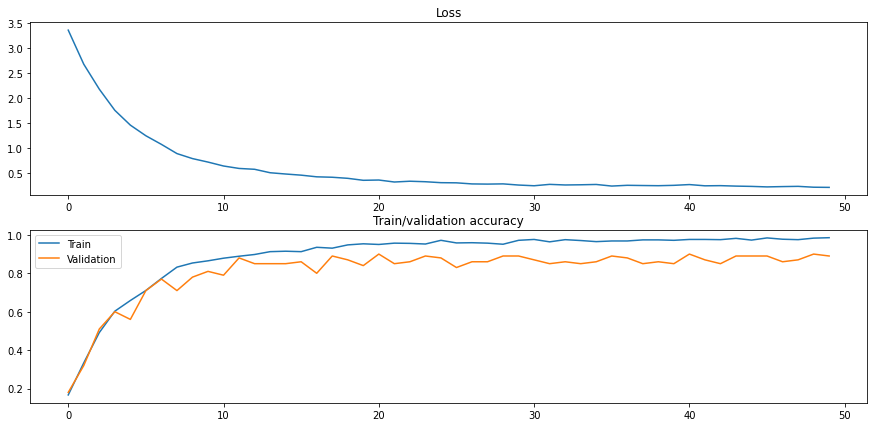

In [133]:
plot_history(loss_history, train_history, val_history)

In [134]:
test_acc = compute_accuracy(model, test_loader)

In [135]:
test_acc

0.81